In [1]:
import os
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import csv
import gc
import glob
sfreq=500 #specified in Matlab scripts

import pandas as pd
import numpy as np
import cv2

path = os.getcwd()

## Read and Preprocess Data

In [2]:
def tsv_to_fif(subj, run, path='C:/Users/HP pavilion X360/Desktop/BCI'):
    stim_code = pd.read_csv(f'{path}/BCI_HSE{subj[1:]}/stim_code/stim_code_{subj}R{run}.csv')
    data = np.zeros((stim_code.shape[0], 13))
    with open(f"{path}/BCI_HSE{subj[1:]}/tsv/BCI_HSE{subj}R{run}.ascii") as tsv:
        i = 0
        for line in csv.reader(tsv, dialect="excel-tab"):
            if i == 0:
                columns = line
                i += 1
            elif i <= stim_code.shape[0]:
                data[i-1] = line
                i += 1
    smart = pd.DataFrame(data, columns = columns)
    smart['STIM101'] = stim_code
    n_channels = 2
    sfreq = 500
    # ch_names = columns
    ch_names = ['Fp1', 'Fp2', 'STIM101']
    ch_types = ['eeg']*2 + ['stim'] #['eeg']*2 + ['misc']*5 + ['eog']*3 + ['misc']*3
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq)
    raw = mne.io.RawArray(smart.values[:, [0, 1, 13]].T, info)

    path_out = f'{path}/BCI_HSE{subj[1:]}/preprocessed/'
    os.makedirs(path_out, exist_ok = True)
    
    raw_filt = raw.copy().filter(
        1, 40, l_trans_bandwidth='auto', picks = ['eeg'],
        h_trans_bandwidth='auto', filter_length='auto', phase='zero',
        fir_window='hamming', fir_design='firwin', n_jobs=4)
    raw_filt.save(f'{path_out}/{subj}R{run}_filt_raw.fif', overwrite = True)
    return raw, raw_filt

In [3]:
subject_list = ['S005']
for subj in subject_list:
    runs = glob.glob(f'{path}/BCI_HSE{subj[1:]}/tsv/*')
    for run in runs:
        raw, raw_filt = tsv_to_fif(subj = subj, run = run[-8:-6])

Creating RawArray with float64 data, n_channels=3, n_times=1102019
    Range : 0 ... 1102018 =      0.000 ...  2204.036 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Overwriting existing file.
Writing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R01_filt_raw.fif


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s finished


Closing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R01_filt_raw.fif
[done]
Creating RawArray with float64 data, n_channels=3, n_times=1102019
    Range : 0 ... 1102018 =      0.000 ...  2204.036 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Overwriting existing file.
Writing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R02_filt_raw.fif


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.6s finished


Closing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R02_filt_raw.fif
[done]
Creating RawArray with float64 data, n_channels=3, n_times=1177019
    Range : 0 ... 1177018 =      0.000 ...  2354.036 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.1s finished


Overwriting existing file.
Writing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R03_filt_raw.fif
Closing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R03_filt_raw.fif
[done]
Creating RawArray with float64 data, n_channels=3, n_times=1177019
    Range : 0 ... 1177018 =      0.000 ...  2354.036 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Overwriting existing file.
Writing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\prepro

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.1s finished


Closing C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE005\preprocessed\S005R04_filt_raw.fif
[done]


## ICA:

In [4]:
def find_ica(subj, run):
    path_out = f'{path}/BCI_HSE{subj[1:]}/preprocessed/'
    from mne.preprocessing import ICA
    %matplotlib qt
    raw = mne.io.read_raw(f"BCI_HSE{subj[1:]}/preprocessed/{subj}R{run}_filt_raw.fif", preload = True)
    ica = ICA(n_components=2, max_iter="auto", random_state=97)
    ica.fit(raw)
    fig = ica.plot_sources(raw, show_scrollbars=False, show = True)
    fig.savefig(f'ICA/{subj}_{run}_ica_comp.png', dpi = 300, bbox_inches = 'tight')
    # raw.save(f'{path_out}/{subj}R{run}_filt_raw_ica.fif', overwrite = True)
    return raw, ica

In [5]:
subj = 'S005'
epo_list = []
runs = ['01', '02', '03', '04']
for run in runs:
    raw, ica = find_ica(subj = subj, run = run)
    if run == '03':
        ica.exclude = [1]
    else:
        ica.exclude = [0]
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)

    events = mne.find_events(raw, stim_channel='STIM101', consecutive = True)
    events[:, 1] = [0] * len(events)
    
    trigg = np.arange(2, np.unique(events[:, 2])[-1], 8)
    for i in range(len(events[:, 2])):
        if events[i, 2] in trigg:
            events[i, 2] = 1
        elif events[i, 2] == 0:
            events[i, 2] = -1
        else:
            events[i, 2] = 0
    
    reject_criteria = dict(
        eeg=10e-2,  # 100 µV
        # eog=200e-6,
    )  # 200 µV
    
    flat_criteria = dict(eeg=1e-13)
    
    os.makedirs(f'BCI_HSE{subj[1:]}/epochs/', exist_ok = True)
    
    event_id = {'stim' : 1, 'distr' : 0}
    epochs = mne.Epochs(
        reconst_raw, tmin=-1, tmax = 2.5, events=events, event_id=event_id, baseline = (-.5, 0),
        reject_tmin = 0, reject_tmax = 1,
        reject=reject_criteria,
        flat=flat_criteria, preload = True)
    epochs.save(f'BCI_HSE{subj[1:]}/epochs/{subj}R{run}_epo.fif', overwrite = True)
    epo_list.append(epochs)

Opening raw data file BCI_HSE005/preprocessed/S005R01_filt_raw.fif...
Isotrak not found
    Range : 0 ... 1102018 =      0.000 ...  2204.036 secs
Ready.
Reading 0 ... 1102018  =      0.000 ...  2204.036 secs...
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 1.4s.
Creating RawArray with float64 data, n_channels=2, n_times=1102019
    Range : 0 ... 1102018 =      0.000 ...  2204.036 secs
Ready.
Using matplotlib as 2D backend.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 1 ICA component
    Projecting back using 2 PCA components
1017 events found
Event IDs: [  1   2   3   4   5   6   9  10  11  12  13  14  17  18  19  20  21  22
  25  26  27  28  29  30  33  34  35  36  37  38  41  42  43  44  45  46
  49  50  51  52  53  54  57  58  59  60  61  62  65  66  67  68  69  70
  73  74  75  76  77  78  81  82  83  84  85  86  89  90  91  92  93  94
  97  98  99 100 1

In [6]:
epo_con = mne.concatenate_epochs(epo_list).crop(tmin = -.2, tmax = .8).resample(500)

Not setting metadata
4136 matching events found
Applying baseline correction (mode: mean)
Sampling frequency of the instance is already 500.0, returning unmodified.


In [ ]:
epo_con['stim'].average().plot()
epo_con['distr'].average().plot()

In [6]:
subj = 'S002'
epo_list = []
for run in ['01', '02', '03', '04']:
    epo = mne.read_epochs(f'BCI_HSE{subj[1:]}/epochs/{subj}R{run}_epo.fif', preload = True).apply_baseline((-.5, 0))
    epo_list.append(epo)
epo_con = mne.concatenate_epochs(epo_list).crop(tmin = -.2, tmax = .8).resample(500)

Reading C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE002\epochs\S002R01_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1027 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE002\epochs\S002R02_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\HP pavilion X360\Desktop\BCI\BCI_HSE002\epochs\S002R03_epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1070 matching eve

## To Plot:::

In [8]:
%matplotlib inline

In [7]:
def plot_stat_comparison_timecourse_1samp_new(comp1, comp2, time, y_low = None, y_high = None, title='demo_title',
                         comp1_label='comp1', comp2_label='comp2'):
    assert(comp1.shape[1] == comp2.shape[1] == len(time))
    fig = plt.figure()
    ax1 = fig.add_subplot()
    
    plt.rcParams['axes.facecolor'] = 'none'
    plt.xlim(time[0], time[-1])
    if y_low is not None:
        plt.ylim(y_low, y_high)
    plt.plot([0, 0.000], [-500, 500], color='k', linewidth=1, linestyle='--', zorder=1)
    plt.plot([-10000, 10000], [0, 0.00], color='k', linewidth=1, linestyle='--', zorder=1)
    plt.plot(time, comp1.mean(axis = 0), color='turquoise', linewidth=1.5, label=comp1_label)
    plt.plot(time, comp2.mean(axis = 0), color='salmon', linewidth=1.5, label=comp2_label)
    
    # ax1.set_ylabel(r'$\mu$V')
    ax1.set_xlabel('Время (мс)')
    
    plt.xticks(ticks=np.arange(time[0], time[-1], 100))
    plt.tick_params(labelsize = 12)
    ax1.legend()

    ci_1 = np.std(comp1, axis = 0)/np.sqrt(comp1.shape[0])
    ci_2 = np.std(comp2, axis = 0)/np.sqrt(comp2.shape[0])
    ax1.fill_between(time, (comp1.mean(axis = 0)-ci_1), (comp1.mean(axis = 0)+ci_1), color='turquoise', alpha=.2)
    ax1.fill_between(time, (comp2.mean(axis = 0)-ci_2), (comp2.mean(axis = 0)+ci_2), color='salmon', alpha=.2)

    plt.title(title, fontsize = 12)
    plt.show()
    return fig

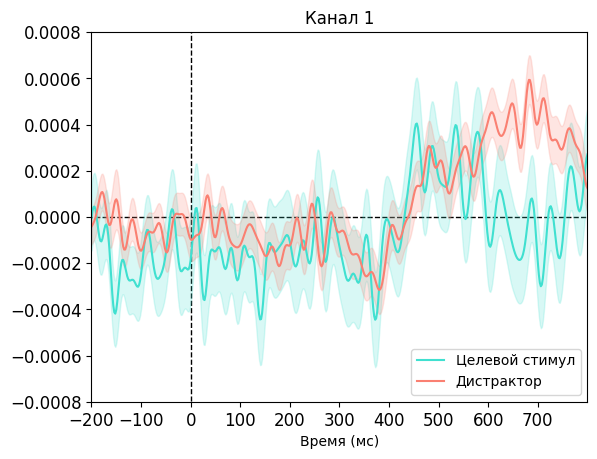

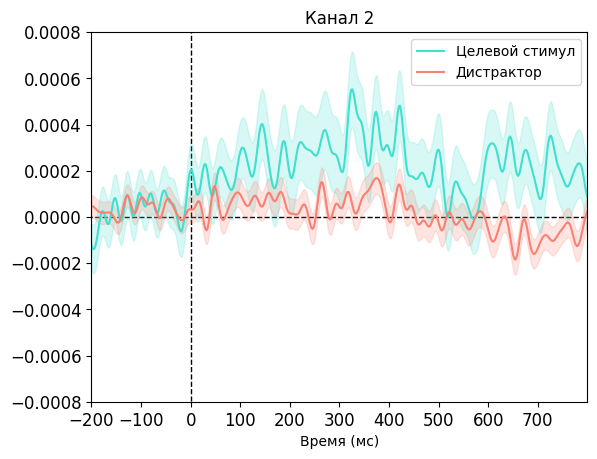

In [11]:
y_high = .0008
y_low = -.0008
ch_1 = plot_stat_comparison_timecourse_1samp_new(comp1=epo_con['stim'].get_data()[:, 0], comp1_label='Целевой стимул',
                                          comp2=epo_con['distr'].get_data()[:, 0], comp2_label='Дистрактор',
                                          time = epo_con.times * 1000,
                                          y_high = y_high, y_low = y_low, 
                                          title = 'Канал 1'
                                                 )
ch_1.savefig(f'output/{subj}_1_{len(epo_con)}epo_ica.png', dpi = 300, bbox_inches = 'tight')

ch_2 = plot_stat_comparison_timecourse_1samp_new(comp1=epo_con['stim'].get_data()[:, 1], comp1_label='Целевой стимул',
                                          comp2=epo_con['distr'].get_data()[:, 1], comp2_label='Дистрактор',
                                          time = epo_con.times * 1000,
                                          y_high = y_high, y_low = y_low, 
                                          title = 'Канал 2'
                                                 )
ch_2.savefig(f'output/{subj}_2_{len(epo_con)}epo_ica.png', dpi = 300, bbox_inches = 'tight')

## To Concat Graphs:::

In [12]:
img1 = cv2.imread(f'output/{subj}_1_{len(epo_con)}epo_ica.png')
img2 = cv2.imread(f'output/{subj}_2_{len(epo_con)}epo_ica.png')

im = cv2.hconcat([img1, img2])
cv2.imwrite(f'output/{subj}_ica.png', im)

True

In [20]:
img1 = cv2.imread(f'output/S002_ica.png')
img2 = cv2.imread(f'output/S004_ica.png')
img3 = cv2.imread(f'output/S005_ica.png')
# img4 = cv2.imread(f'output/S007_ica.png')

im = cv2.vconcat([img1, img2, img3])
cv2.imwrite(f'output/GRAPH_concat.png', im)

True

In [21]:
def get_one_image(images):
        img_list = []
        padding = 200
        for img in images:
            img_list.append(cv2.imread(img))
        max_width = []
        max_height = 0
        for img in img_list:
            max_width.append(img.shape[0])
            max_height += img.shape[1]
        w = np.max(max_width)
        h = max_height + padding

        # create a new array with a size large enough to contain all the images
        final_image = np.zeros((h, w, 3), dtype=np.uint8)

        current_y = 0  # keep track of where your current image was last placed in the y coordinate
        for image in img_list:
            # add an image to the final array and increment the y coordinate
            final_image[current_y:image.shape[0] + current_y, :image.shape[1], :] = image
            current_y += image.shape[0]
        cv2.imwrite('out.png', final_image)

In [25]:
image_names = ['output/S004_ica.png', 'output/S005_ica.png', 'output/S007_ica.png',
         'output/S002_ica.png']
images = []
max_width = 0 # find the max width of all the images
total_height = 0 # the total height of the images (vertical stacking)

for name in image_names:
    # open all images and find their sizes
    images.append(cv2.imread(name))
    if images[-1].shape[1] > max_width:
        max_width = images[-1].shape[1]
    total_height += images[-1].shape[0]

# create a new array with a size large enough to contain all the images
final_image = np.zeros((total_height,max_width,3),dtype=np.uint8)

current_y = 0 # keep track of where your current image was last placed in the y coordinate
for image in images:
    # add an image to the final array and increment the y coordinate
    final_image[current_y:image.shape[0]+current_y,:image.shape[1],:] = image
    current_y += image.shape[0]

cv2.imwrite('out.png',final_image)

True